In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score,roc_curve
from joblib import Parallel, delayed
from sklearn.utils import resample
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 22})

import sys
sys.path.append("/home/icb/sergey.vilov/workspace/MLM/utils") 

from misc import model_bar_colors, model_colors

%load_ext autoreload
%autoreload 2

In [2]:
data_dir='/lustre/groups/epigenereg01/workspace/projects/vale/mlm/motif_analysis/'

In [3]:
def calculate_auc(y_true, y_pred, seed):
    y_pred_resampled, y_true_resampled = resample(y_pred, y_true, random_state=seed)
    auc = roc_auc_score(y_true_resampled, y_pred_resampled)
    return auc

def bootstrap_score_parallel(y_true, y_pred, scoring_func,
                             n_iterations=1000, ci_percentile=95):

    all_scores = Parallel(n_jobs=-1)(delayed(scoring_func)(y_true, y_pred, i) for i in range(n_iterations))

    # Compute the confidence interval
    ci_lower = np.percentile(all_scores, (100 - ci_percentile) / 2)
    ci_upper = np.percentile(all_scores, 100 - (100 - ci_percentile) / 2)
    
    score_mean = np.mean(all_scores)
    score_err = (ci_upper-ci_lower)/2
    
    return score_mean,score_err

def score(df, n_bootstrap=100):
    
    y_true,y_pred = df[['functional','score']].values.T
    y_true, y_pred = y_true.astype(int), y_pred.astype(float) 
    
    score_mean, score_err = bootstrap_score_parallel(y_true, y_pred, scoring_func=calculate_auc, n_iterations=n_bootstrap)
    
    return (score_mean, score_err, y_true, y_pred)

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    a = a[~np.isnan(a)]
    n = len(a)
    m, se = np.nanmean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [4]:
motif_len = 5
agg_strategy = 'MEAN' #MEAN or MAX
LM_scoring = 'ref' # 'ref', 'alt' or 'ref_vs_alt'

In [5]:
motifs_tsv = data_dir + f'../all_scores/motifs_k{motif_len}_agg_{agg_strategy}_zoo-al_hs.tsv.gz'

In [6]:
#functional score for all models
model_res_all = pd.read_csv(motifs_tsv,sep='\t')
model_res_all.rename(columns={'eCLIP_RBNS':'functional'},inplace=True)

In [7]:
model_res_all['score'] = model_res_all.apply(lambda x: x.score_ref if x.model.startswith('PhyloP') or x.model=='Zoo-AL' else
                                                       x.score_alt if x.model.startswith('CADD') else
                                                       x[f'score_{LM_scoring}'], axis=1)

In [8]:
model_res_all=model_res_all[['UTR_ID','motif_start_UTR','RBP','motif','score','functional','model']]

model_res_all = pd.pivot(model_res_all,columns='model',index=['UTR_ID','motif_start_UTR','RBP','motif','functional'],
         values='score').reset_index()

In [9]:
conservation_tsv = data_dir + f'conservation_k{motif_len}.tsv'
conservation_df = pd.read_csv(conservation_tsv,sep='\t')
conservation_df.rename(columns={'seq_name':'UTR_ID','motif_start':'motif_start_UTR'},inplace=True)
conservation_df = conservation_df[['UTR_ID','motif','motif_start_UTR','R_0']]

In [10]:
model_res_all = model_res_all.merge(conservation_df, how='left')

In [11]:
cons_model = 'PhyloP-241way'

model_res_pos = model_res_all.loc[(model_res_all.functional==True),['UTR_ID', 'motif_start_UTR', 'RBP', 'motif',cons_model]].copy()
model_res_pos['RBP'] = model_res_pos.RBP.astype(str).apply(lambda x:x.split(','))
model_res_pos = model_res_pos.explode('RBP')
model_res_pos['group'] = model_res_pos.RBP + '_'  + model_res_pos.motif

In [12]:
model_res_pos['group'].nunique()

102

In [13]:
group_pct_top = model_res_pos.groupby('group')[cons_model].apply(lambda x: np.nanpercentile(x,90))
group_pct_bottom = model_res_pos.groupby('group')[cons_model].apply(lambda x: np.nanpercentile(x,10))

In [14]:
model_res_pos['bottom'] = model_res_pos.apply(lambda x:x[cons_model]<=group_pct_bottom[x.group],axis=1)
model_res_pos['top'] = model_res_pos.apply(lambda x:x[cons_model]>=group_pct_top[x.group],axis=1)

In [15]:
#model_res_neg = model_res_all.loc[(model_res_all.functional==False),['UTR_ID', 'motif_start_UTR', 'RBP', 'motif']]

In [16]:
#n_top_motifs = model_res_pos[model_res_pos.top==True].motif.value_counts()
#neg_idx_top = model_res_neg[model_res_neg.motif.isin(n_top_motifs.index)].groupby('motif').apply(lambda x:x.sample(n=n_top_motifs[x.name],random_state=1,replace=False),include_groups=False).index.get_level_values(-1)

In [17]:
#n_bottom_motifs = model_res_pos[model_res_pos.bottom==True].motif.value_counts()
#neg_idx_bottom = model_res_neg[model_res_neg.motif.isin(n_bottom_motifs.index)].groupby('motif').apply(lambda x:x.sample(n=n_bottom_motifs[x.name],random_state=1,replace=False),include_groups=False).index.get_level_values(-1)

In [18]:
model_res_all = model_res_all.merge(model_res_pos[['UTR_ID','motif_start_UTR','motif','top','bottom']],how='left')

In [19]:
#model_res_all.loc[neg_idx_bottom,'bottom']=True
#model_res_all.loc[neg_idx_top,'top']=True

In [20]:
models = ['DNABERT','DNBT-3UTR-RNA',
          'NT-MS-v2-100M','NT-3UTR-RNA',
          'STSP-3UTR-RNA','STSP-3UTR-RNA-HS','STSP-3UTR-DNA',
         'PhyloP-100way','PhyloP-241way','CADD-1.7','Zoo-AL']

all_scores = []
roc_curves = {}

for model in models:

    print(model)

    for how in ('top','bottom','all'):

        if how=='all':
            df = model_res_all
        else:
            df = model_res_all[(model_res_all.functional==False)|(model_res_all[how]==True)]
            #df = model_res_all[(model_res_all[how]==True)]
        
        df = df[~np.isnan(df[model])]

        y_true = df.functional.astype(int)
        y_pred = df[model].astype(float)

        _,yerr=bootstrap_score_parallel(y_true,y_pred,scoring_func=calculate_auc,n_iterations=100)
        
        score = roc_auc_score(y_true,y_pred)
        
        roc_curves[(model,how)] = (score,yerr,y_true,y_pred)
        
        all_scores.append((model,how,score,yerr))

all_scores = pd.DataFrame(all_scores,columns=['model','how','score','yerr'])

DNABERT
DNBT-3UTR-RNA
NT-MS-v2-100M
NT-3UTR-RNA
STSP-3UTR-RNA
STSP-3UTR-RNA-HS
STSP-3UTR-DNA
PhyloP-100way
PhyloP-241way
CADD-1.7
Zoo-AL


In [21]:
import sys
sys.path.append("/home/icb/sergey.vilov/workspace/MLM/utils") 

import misc

df = all_scores.copy().set_index('model')#.loc[['DNABERT','DNABERT-3UTR','NT-MS-v2-100M','NTv2-100M-3UTR','StateSpace','StateSpace-DNA','StateSpace-HS',
                                         #    'PhyloP-100way','PhyloP-241way','CADD-1.7','Zoo-AL']]


df['score'] = df.apply(lambda x: (x.score,x.yerr),axis=1 )

scores_all = df[df.how=='all'].score.rename('all motifs')
scores_bottom10 = df[(df.how=='bottom')].score.rename(f'bottom {10}% conservation')
scores_top10 = df[(df.how=='top')].score.rename(f'top {10}% conservation')

summary_df = pd.concat([scores_all,scores_top10,scores_bottom10],axis=1)

best_models = summary_df.apply(misc.get_best_models).to_dict()

summary_df_ = summary_df.map(lambda x: f'{x[0]:.3f}±{x[1]:.3f}')

summary_df_.style.apply(lambda x: misc.highlight_ns(x, best_models))

,all motifs,top 10% conservation,bottom 10% conservation
model,,,
DNABERT,0.595±0.003,0.543±0.007,0.608±0.008
DNBT-3UTR-RNA,0.629±0.004,0.602±0.007,0.627±0.008
NT-MS-v2-100M,0.603±0.003,0.547±0.007,0.629±0.007
NT-3UTR-RNA,0.703±0.003,0.829±0.005,0.600±0.007
STSP-3UTR-RNA,0.649±0.003,0.612±0.007,0.651±0.007
STSP-3UTR-RNA-HS,0.656±0.003,0.606±0.006,0.656±0.008
STSP-3UTR-DNA,0.650±0.003,0.615±0.007,0.651±0.007
PhyloP-100way,0.620±0.003,0.884±0.004,0.365±0.007
PhyloP-241way,0.649±0.003,0.972±0.001,0.136±0.003


In [22]:
model_res_all.groupby('functional')[cons_model].median()

functional
False    1.107
True     2.181
Name: PhyloP-241way, dtype: float64

In [23]:
model_res_all.loc[(model_res_all.functional==True)&(model_res_all.top==True),cons_model].median()

np.float64(6.357)

In [24]:
model_res_all.loc[(model_res_all.functional==True)&(model_res_all.bottom==True),cons_model].median()

np.float64(0.193)

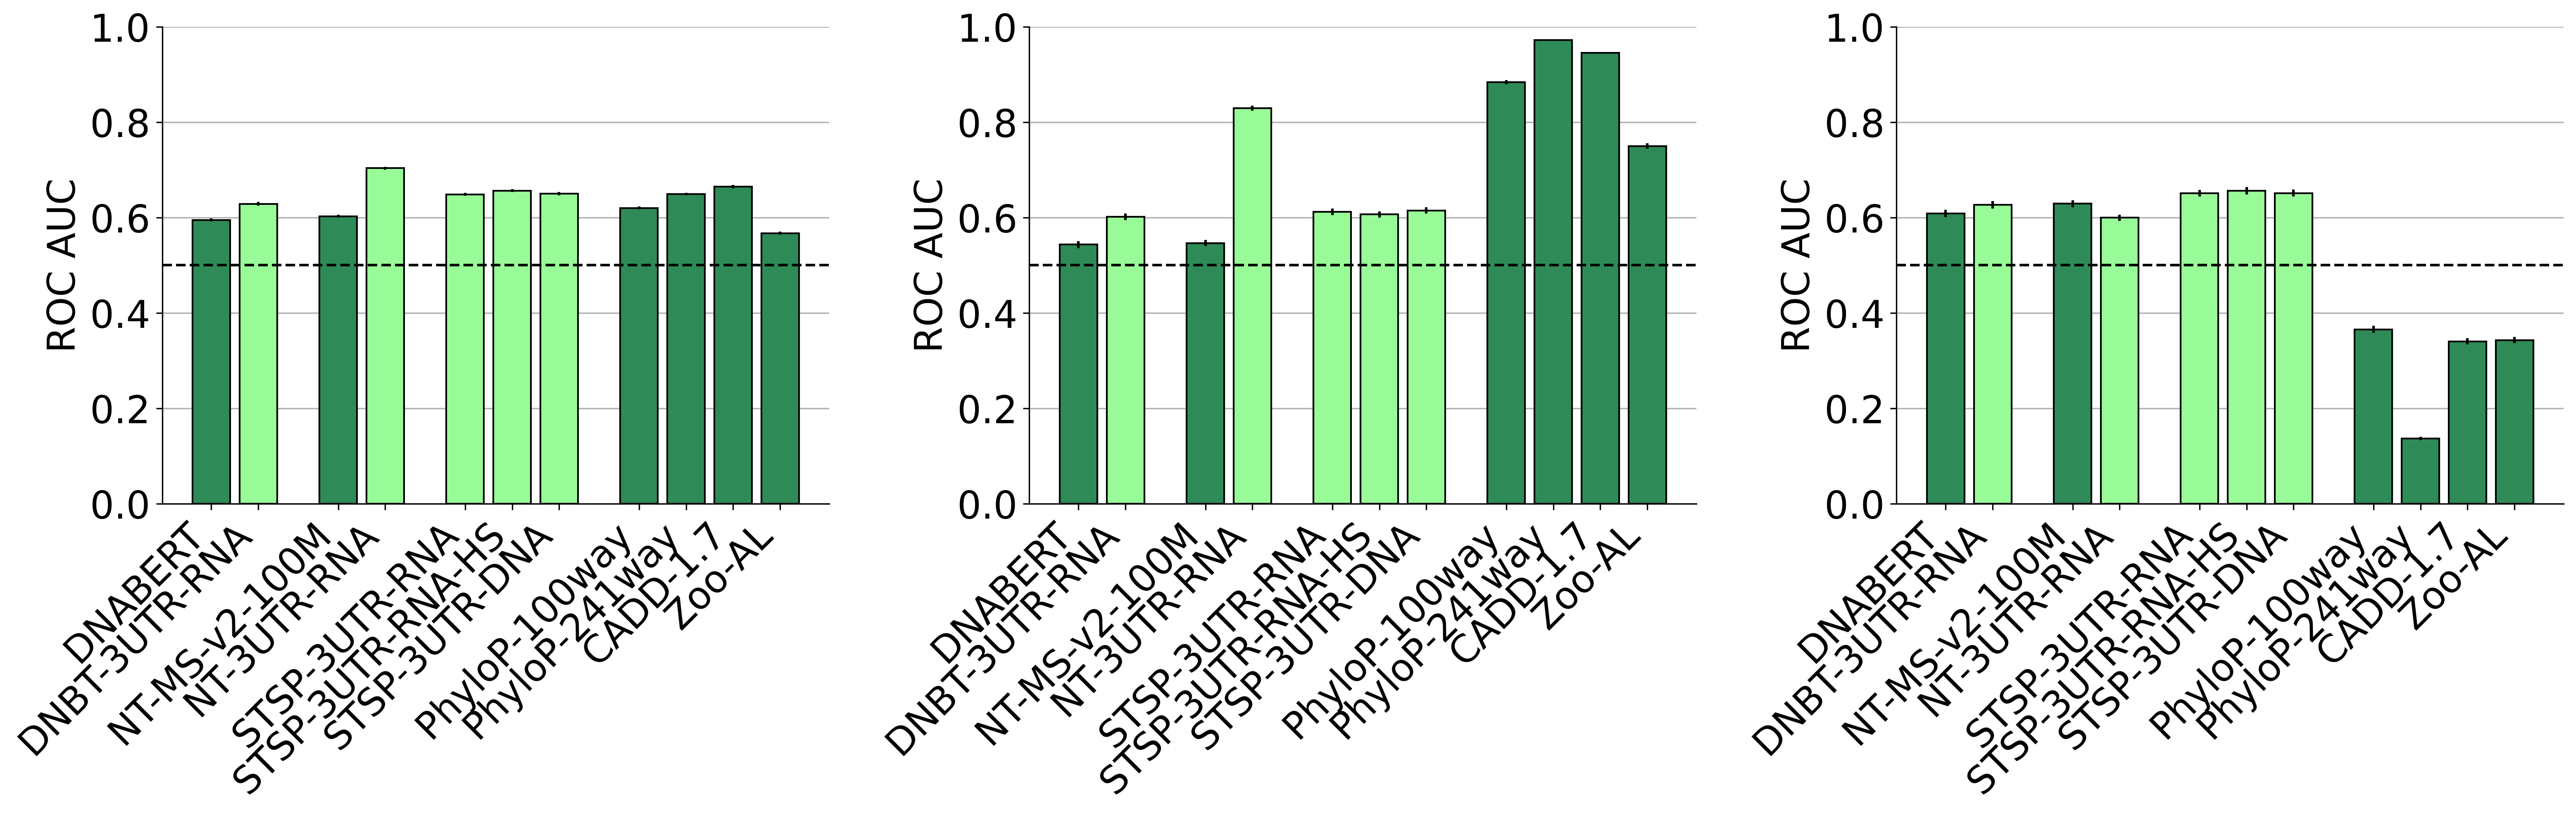

In [25]:
fig, axes = plt.subplots(1,3, dpi=300, figsize=(25,5))

axes = axes.flatten()

for ax_idx,ax in enumerate(axes):

    if ax_idx==2:
        odds_ratios = all_scores[(all_scores.how=='bottom')].set_index('model')
        #ax.set_title(f'bottom {10}% conservation')
    elif ax_idx==1:
        odds_ratios = all_scores[(all_scores.how=='top')].set_index('model')
        #ax.set_title(f'top {10}% conservation')
    else:
        odds_ratios = all_scores[all_scores.how=='all'].set_index('model')
        #ax.set_title('all motifs')
        
    offset = 0

    xticks = []
    for idx, (model, row) in enumerate(odds_ratios.iterrows()):
        if model in ('DNABERT2','NT-MS-v2-100M','STSP-3UTR-RNA','DNABERT','PhyloP-100way'):
            offset+=0.7
        ax.bar(offset+idx, row.score, yerr=row.yerr, color=model_bar_colors[model], edgecolor='black')
        xticks.append(offset+idx)
        
    ax.set_xticks(xticks, odds_ratios.index, rotation=45, ha="right");
    ax.grid(axis='y')
    ax.set_axisbelow(True)


    ax.axhline(0.5,color='k', linestyle='--')
    #ax.axhline(3.13,0,len(models),color='lightgray', linestyle='--')
    ax.set_ylim([0.,1])
    ax.set_ylabel('ROC AUC')

        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.subplots_adjust(wspace=0.3)

In [26]:
best_score_list = all_scores.groupby('how').apply(lambda x:x.sort_values(by='score',ascending=False).iloc[:3].set_index('model').score)

/tmp/ipykernel_429546/2184412605.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_score_list = all_scores.groupby('how').apply(lambda x:x.sort_values(by='score',ascending=False).iloc[:3].set_index('model').score)


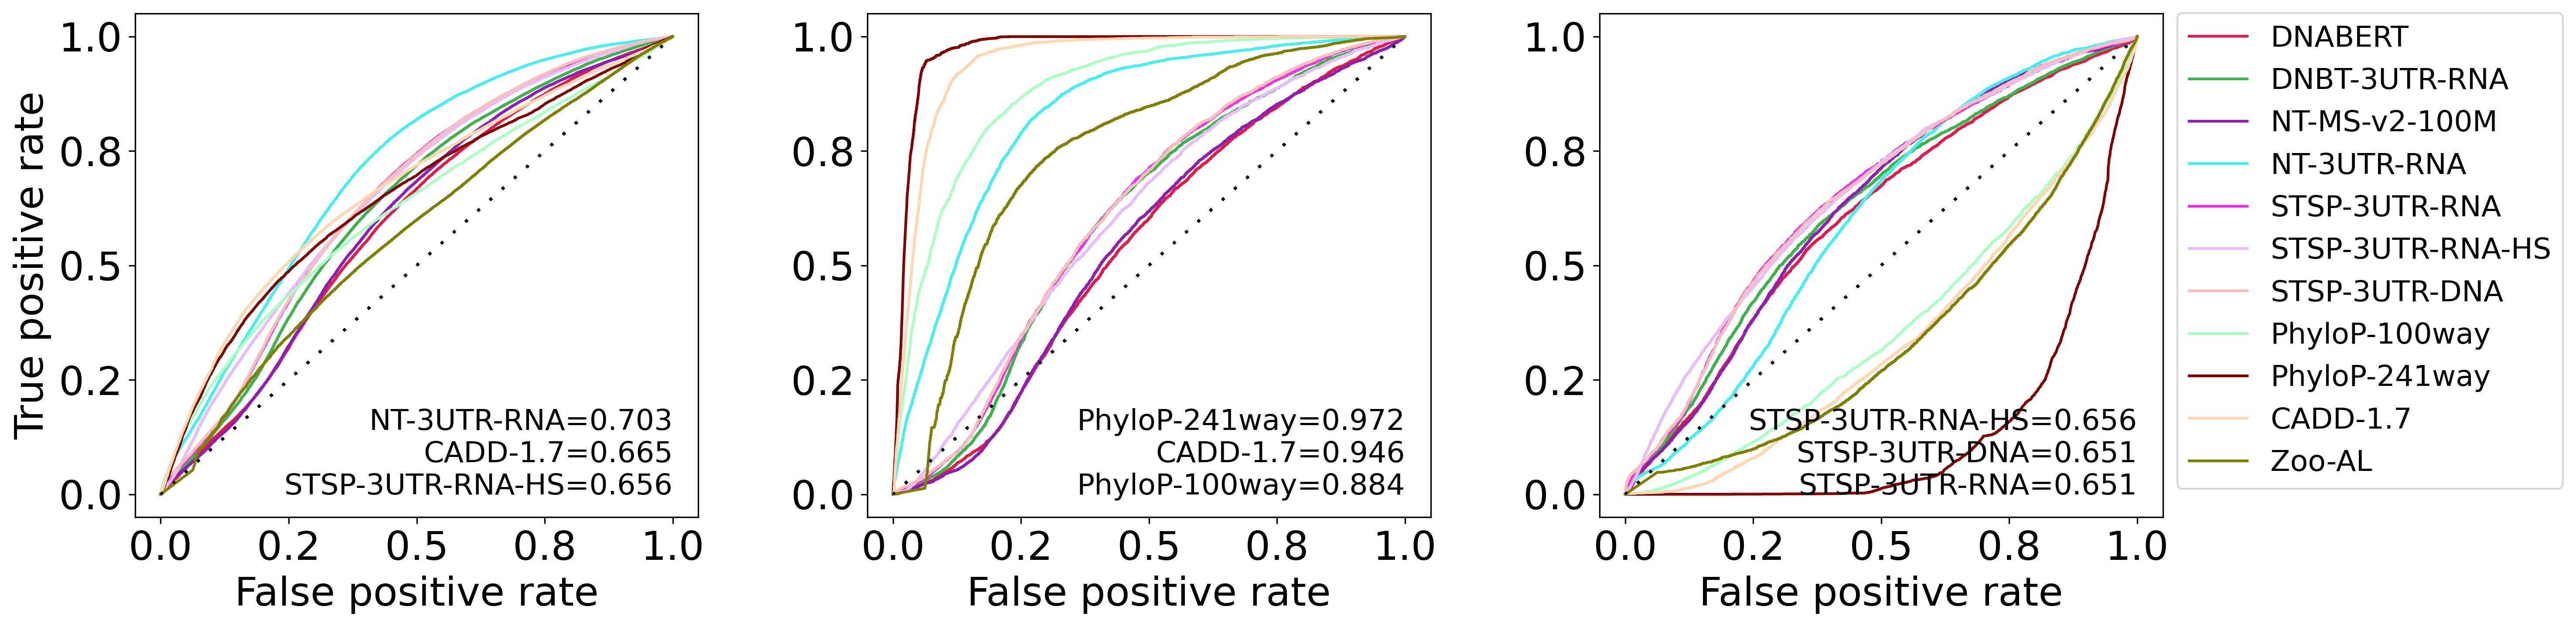

In [26]:
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(1,3, figsize=(20,5),dpi=300)

x = np.arange(0,1,0.01)

for ax_idx,ax in enumerate(axes):

    text=[]
    
    for model_name in models:
        if ax_idx == 0:
            auc, yerr, y_true, y_pred = roc_curves[(model_name,'all')]
            how='all'
        elif ax_idx==2:
            auc, yerr, y_true, y_pred = roc_curves[(model_name,'bottom')]
            how='bottom'
        else:
            auc, yerr, y_true, y_pred = roc_curves[(model_name,'top')]
            how='top'

        fpr, tpr, _ = roc_curve(y_true,y_pred)
        #if auc<0.5:
        #    fpr, tpr = tpr, fpr
        ax.plot(fpr,tpr,color=model_colors[model_name],label=model_name)
        ax.plot(x,x, linestyle=(0,(1,5)), color='k')
        ax.set_xticks([0,0.25,0.5,0.75,1])
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_yticks([0,0.25,0.5,0.75,1])
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
    for model,auc in best_score_list.loc[how].items():
        text.append(f'{model}={auc:.3f}')
        
    ax.text(1,0,'\n'.join(text),horizontalalignment='right',fontsize=16)
    
    if ax_idx==0:
        ax.set_ylabel('True positive rate')
    ax.set_xlabel('False positive rate')
    
    if ax_idx==2:
        ax.legend(bbox_to_anchor=(1., 1.03),ncol=1, fontsize=16)

#    if how=='all':
#        ax.set_title(f'all motifs')
#    elif how=='bottom':
#        ax.set_title(f'bottom {mobility_pct_bottom}% mobility')
#    else:
#        ax.set_title(f'top {mobility_pct_top}% mobility')

plt.subplots_adjust(wspace=0.3)

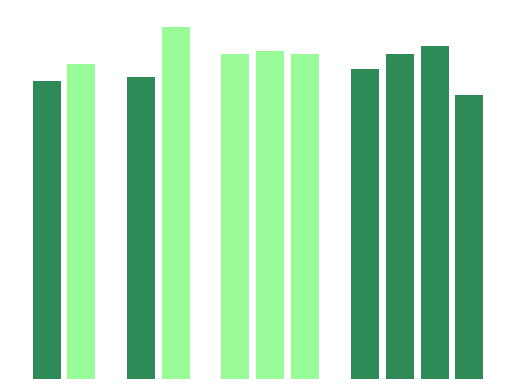

In [32]:
odds_ratios = all_scores[all_scores.how=='all'].set_index('model')
        
offset = 0
fig, ax = plt.subplots()

for idx, (model, row) in enumerate(odds_ratios.iterrows()):
        if model in ('DNABERT2','NT-MS-v2-100M','STSP-3UTR-RNA','DNABERT','PhyloP-100way'):
            offset+=0.7
        ax.bar(offset+idx, row.score, color=model_bar_colors[model], edgecolor=None)

ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)